In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm
tqdm.pandas()

In [3]:
data_path = Path('kkbox-music-recommendation-challenge')

# Feature engineering
### Songs features

In [4]:
songs = pd.read_csv(data_path / 'songs.csv')
song_extra_info = pd.read_csv(data_path / 'song_extra_info.csv')

In [5]:
songs = songs.merge(song_extra_info, on='song_id', how='left')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN


In [6]:
def number_of(x, column_name):
    value = x[column_name]
    if pd.isna(value):
        return 0
    value = str(value)
    return 1 + value.count('|') + value.count('/') + value.count('//') + value.count('&') + value.count(';') + value.count('and')

def count_of(df, column_name):
    return df.progress_apply(lambda x: number_of(x, column_name), axis=1)

In [7]:
songs['num_genres'] = count_of(songs, 'genre_ids')
songs['num_artists'] = count_of(songs, 'artist_name')
songs['num_composers'] = count_of(songs, 'composer')
songs['num_lyricists'] = count_of(songs, 'lyricist')

In [8]:
def isrc_to_year(isrc):
    if pd.isna(isrc):
        return isrc
    if int(isrc[5:7]) > 17:
        return 1900 + int(isrc[5:7])
    return 2000 + int(isrc[5:7])

In [9]:
songs['year'] = songs['isrc'].progress_apply(isrc_to_year)

In [10]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,num_genres,num_artists,num_composers,num_lyricists,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010,1,1,1,1,2014.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN,1,1,3,1,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN,1,1,0,0,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108,1,1,1,1,2002.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN,1,1,1,1,NaN


In [11]:
songs['artist_name'] = songs['artist_name'].str.lower()
song_columns_to_drop = ['composer', 'lyricist', 'name', 'isrc']
songs = songs.drop(columns=song_columns_to_drop)

In [12]:
songs.head()

,song_id,song_length,genre_ids,artist_name,language,num_genres,num_artists,num_composers,num_lyricists,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (jeff chang),3.0,1,1,1,1,2014.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,blackpink,31.0,1,1,3,1,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,super junior,31.0,1,1,0,0,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,s.h.e,3.0,1,1,1,1,2002.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,52.0,1,1,1,1,NaN


### Members features
> bd: age. Note: this column has outlier values, please use your judgement.

In [13]:
members = pd.read_csv(data_path / 'members.csv')

In [14]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [15]:
members.loc[(members['bd'] < 12) | (members['bd'] > 100), 'bd'] = np.nan

In [16]:
def extract_date(x):
    x = str(x)
    year = int(x[:4])
    month = int(x[4:6])
    day = int(x[6:])
    return [day, month, year]

from datetime import datetime

def how_long_user(x):
    start_date = datetime(year=x['registration_year'], month=x['registration_month'], day=x['registration_day'])
    end_date = datetime(year=x['expiration_year'], month=x['expiration_month'], day=x['expiration_day'])
    return (end_date - start_date).days

In [17]:
members[['registration_day', 'registration_month', 'registration_year']] = members.progress_apply(lambda x: extract_date(x['registration_init_time']), result_type='expand', axis=1)
members[['expiration_day', 'expiration_month', 'expiration_year']] = members.progress_apply(lambda x: extract_date(x['expiration_date']), result_type='expand', axis=1)

members['how_long_user'] = members.progress_apply(how_long_user, axis=1)

In [18]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_day,registration_month,registration_year,expiration_day,expiration_month,expiration_year,how_long_user
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,NaN,NaN,7,20110820,20170920,20,8,2011,20,9,2017,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,NaN,NaN,7,20150628,20170622,28,6,2015,22,6,2017,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,NaN,NaN,4,20160411,20170712,11,4,2016,12,7,2017,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,NaN,NaN,9,20150906,20150907,6,9,2015,7,9,2015,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,NaN,NaN,4,20170126,20170613,26,1,2017,13,6,2017,138


In [19]:
members_to_drop = ['registration_init_time', 'expiration_date']
members = members.drop(columns=members_to_drop)

In [20]:
import gc
gc.collect()

78

### Train

In [21]:
train = pd.read_csv(data_path / 'train.csv')
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [47]:
train['is_local'] = train['source_type'].str.contains('local').astype(np.bool)
train['is_playlist'] = train['source_type'].str.contains('playlist').astype(np.bool)
train['is_discover'] = train['source_screen_name'].str.contains('Discover').astype(np.bool)
train['is_search'] = train['source_screen_name'].str.contains('Search').astype(np.bool)

In [48]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,is_local,is_playlist,is_discover,is_search,...,how_long_user,song_length,genre_ids,artist_name,language,num_genres,num_artists,num_composers,num_lyricists,year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,False,True,False,False,...,2103,206471.0,359,bastille,52.0,1.0,1.0,2.0,0.0,2016.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,2301,284584.0,1259,various artists,52.0,1.0,1.0,0.0,0.0,1999.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,2301,225396.0,1259,nas,52.0,1.0,1.0,1.0,0.0,2006.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,2301,255512.0,1019,soundway,-1.0,1.0,1.0,1.0,0.0,2010.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,False,True,False,False,...,2103,187802.0,1011,brett young,52.0,1.0,1.0,3.0,0.0,2016.0


In [24]:
train = train.merge(members, on='msno', how='left')
train = train.merge(songs, on='song_id', how='left')

In [25]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,is_local,is_playlist,is_discover,is_search,...,how_long_user,song_length,genre_ids,artist_name,language,num_genres,num_artists,num_composers,num_lyricists,year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,False,True,False,False,...,2103,206471.0,359,bastille,52.0,1.0,1.0,2.0,0.0,2016.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,2301,284584.0,1259,various artists,52.0,1.0,1.0,0.0,0.0,1999.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,2301,225396.0,1259,nas,52.0,1.0,1.0,1.0,0.0,2006.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,2301,255512.0,1019,soundway,-1.0,1.0,1.0,1.0,0.0,2010.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,False,True,False,False,...,2103,187802.0,1011,brett young,52.0,1.0,1.0,3.0,0.0,2016.0


In [26]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'is_local', 'is_playlist', 'is_discover',
       'is_search', 'city', 'bd', 'gender', 'registered_via',
       'registration_day', 'registration_month', 'registration_year',
       'expiration_day', 'expiration_month', 'expiration_year',
       'how_long_user', 'song_length', 'genre_ids', 'artist_name', 'language',
       'num_genres', 'num_artists', 'num_composers', 'num_lyricists', 'year'],
      dtype='object')

In [49]:
import category_encoders as ce
categorical_columns = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name', 'city', 'gender', 'registered_via', 'genre_ids', 'language']
encoder = ce.OrdinalEncoder(cols=categorical_columns)

In [50]:
X, y = train.drop(columns=['msno', 'song_id', 'target']), train['target']

In [51]:
feature_names = list(X.columns)

In [52]:
X = encoder.fit_transform(X)

C:\Miniconda3\envs\recsys\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [53]:
from lightgbm import LGBMClassifier

In [54]:
clf = LGBMClassifier(
            # boosting_type='dart', # - при использовании dart можно улучшить метрики (правда модель обучается сильно дольше)
            n_estimators=int(1e6), # - будем строить деревья, пока не упремся в overfitting по validate
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.3,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            verbose=0 
)

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [57]:
clf.fit(
        X_train, y_train, 
        eval_set= [(X_train, y_train), (X_valid, y_valid)], 
        eval_metric='auc', verbose=100, early_stopping_rounds=500, 
        feature_name=feature_names, categorical_feature=categorical_columns
)

C:\Miniconda3\envs\recsys\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Miniconda3\envs\recsys\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'city', 'gender', 'genre_ids', 'language', 'registered_via', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 2785259, number of negative: 2747804
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.907951
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.234797
[LightGBM] [Debug] init for col-wise cost 0.098128 seconds, init for row-wise cost 0.294823 seconds
[LightGBM] [Debug] col-wise cost 0.040489 seconds, row-wise cost 0.041440 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.376752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5436
[LightGBM] [Info] Number of data points in the train set: 5533063, number of used features: 27


C:\Miniconda3\envs\recsys\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Miniconda3\envs\recsys\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503385 -> initscore=0.013539
[LightGBM] [Info] Start training from score 0.013539
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
Training until validation scores don't improve for 500 rounds
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves =

KeyboardInterrupt: 

In [ ]:
X['is_local'].astype(np.bool).unique()

In [43]:
X['is_local'].astype(np.bool)

0          False
1           True
2           True
3           True
4          False
           ...  
7377413     True
7377414    False
7377415    False
7377416    False
7377417    False
Name: is_local, Length: 7377418, dtype: bool

In [44]:
X['is_local'].isna().sum()

21539

In [46]:
21539 / X['is_local'].shape[0]

0.0029195851448298037

# Feature importance

In [59]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [60]:
def plot_importance(model, importance_type='split'):
    """
    importance_type could be split or 'gain'
    """
    feat_importance = pd.DataFrame()
    feat_importance["feature"] = X_train.columns
    feat_importance[importance_type] = model.feature_importance(importance_type=importance_type)
    feat_importance = feat_importance.sort_values(by=importance_type, ascending=False).head(20)
    fig = plt.figure(figsize=(20, 10)) 
    ax = sns.barplot(y="feature", x=importance_type, data=feat_importance) 
    plt.show() 
    fig.savefig(f"feature_importance_{importance_type}.png")

In [61]:
plot_importance(clf.booster_, importance_type='split')

NotFittedError: No booster found. Need to call fit beforehand.

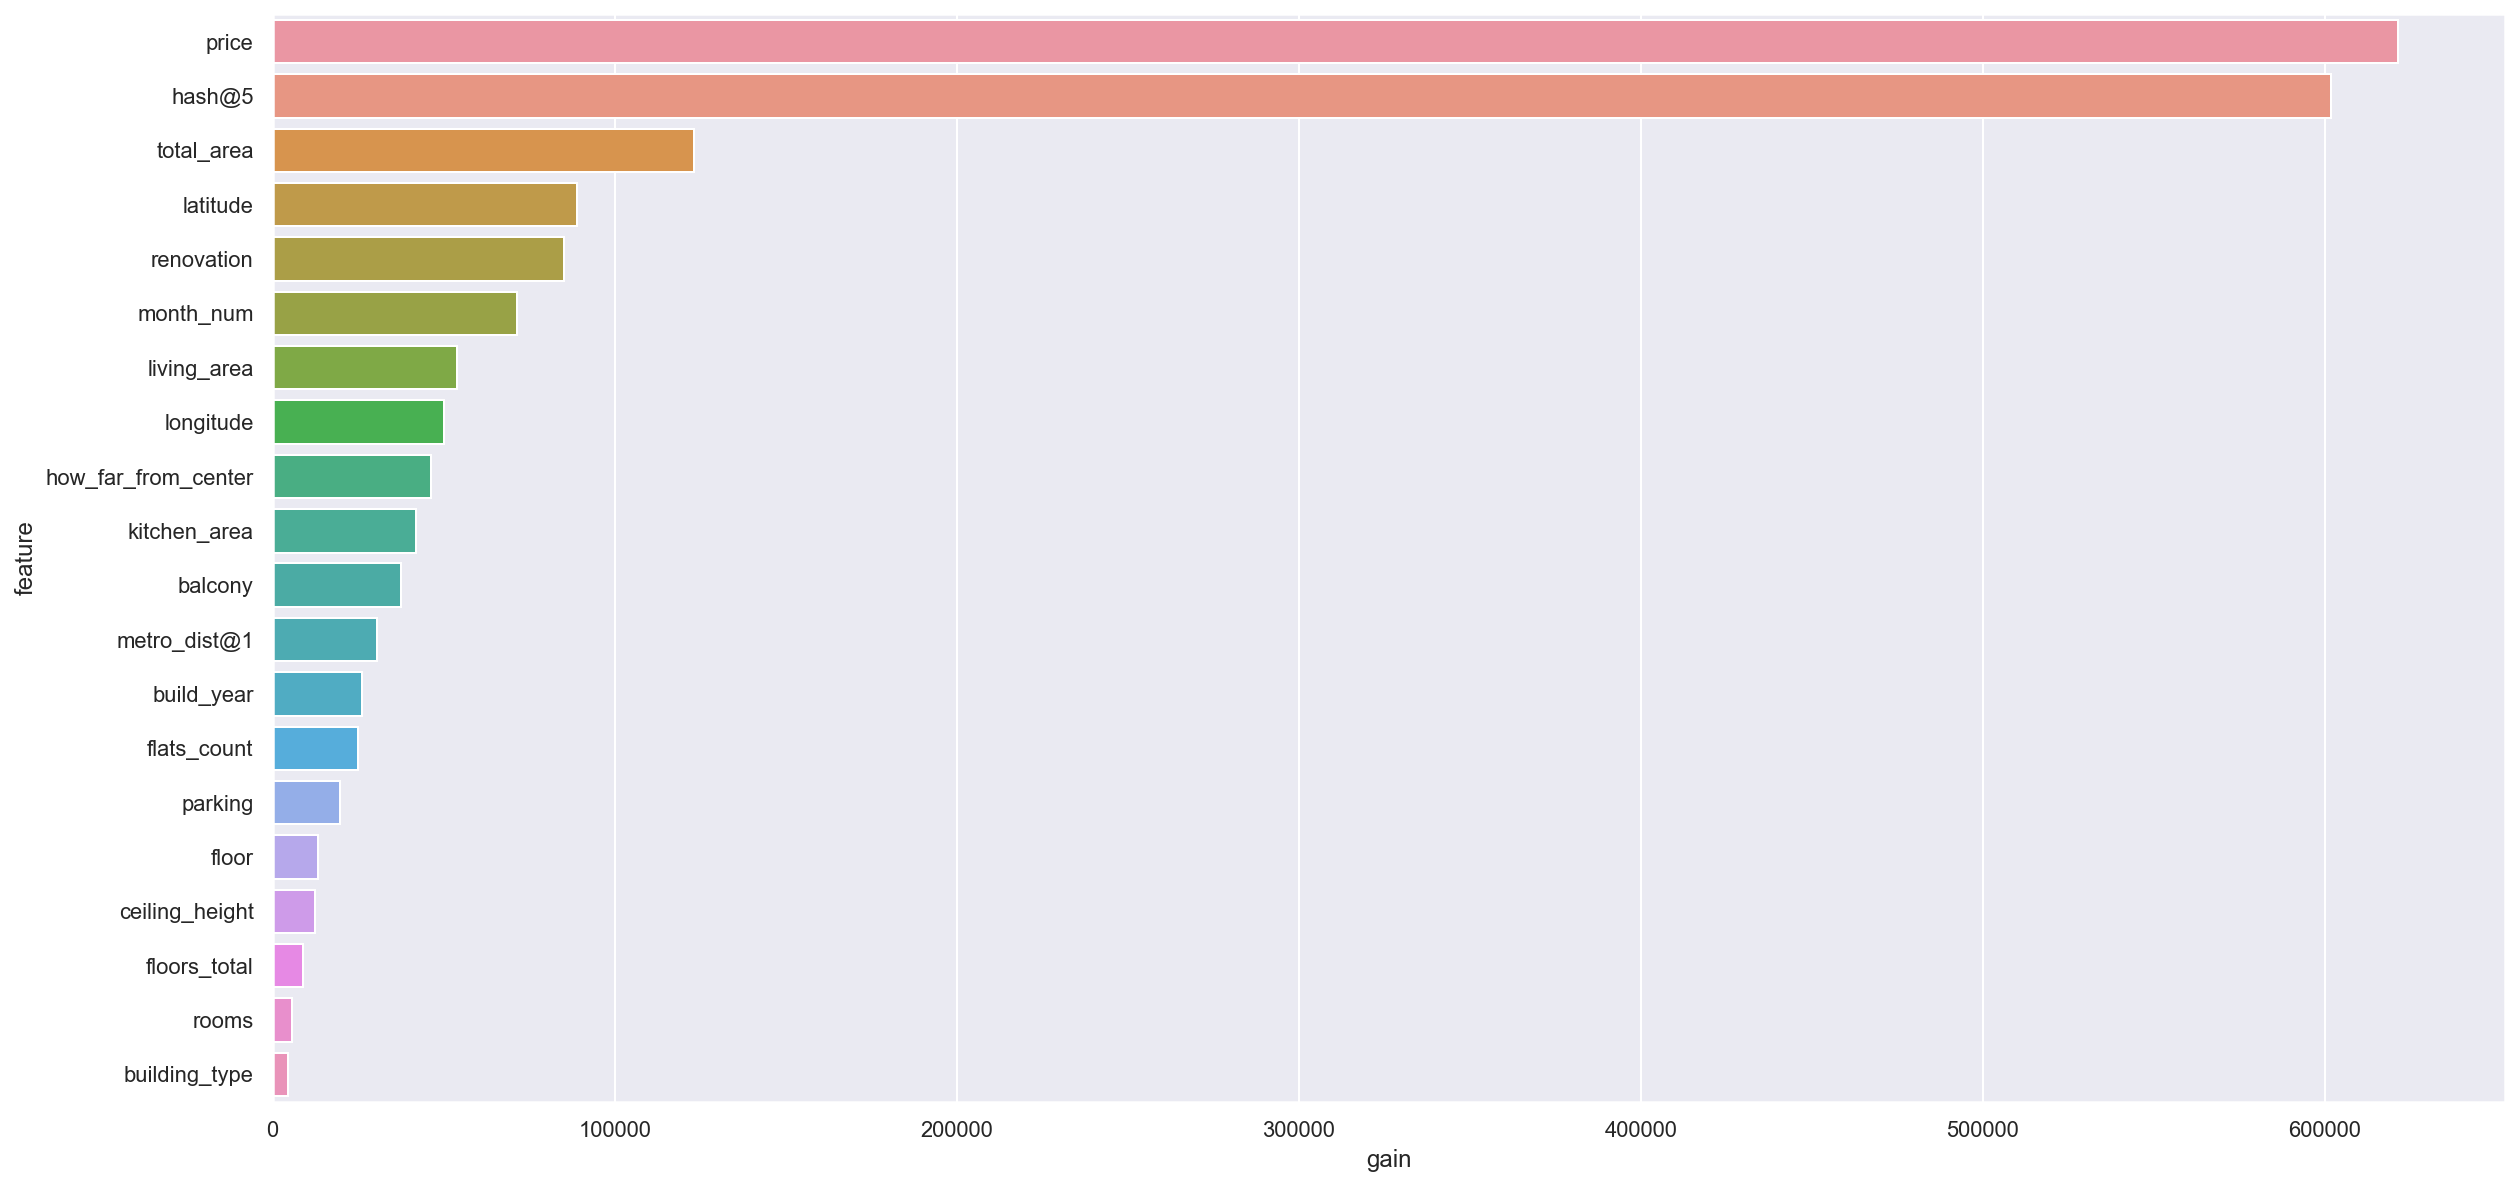

In [1200]:
plot_importance(clf.booster_, importance_type='gain')

Опционально можно построить важности признаков при помощи [shap](https://github.com/slundberg/shap)

In [ ]:
use_shap = True

In [ ]:
if use_shap:
    import shap 
    shap.initjs()
    shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
    shap.summary_plot(shap_values, X_train)